In [202]:
import hashlib
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
import io
import logging
import pandas as pd
import pandahouse
from read_db.CH import Getch
import os
sns.set

<function seaborn.rcmod.set(*args, **kwargs)>

In [203]:
def ab_split(id, salt='exp_mess_1', n_groups=5):
    test_id = str(id) + '-' + str(salt)
    test_id_digest = hashlib.md5(test_id.encode('ascii')).hexdigest()
    test_id_final_int = int(test_id_digest, 16)
    return test_id_final_int % n_groups

In [204]:
connection = {}

q = """
SELECT distinct user_id
FROM db_name 
WHERE toDate(time) >= '2022-03-08' and toDate(time) <= '2022-03-14' 
"""

# Вытащили пользователей
users_df = pandahouse.read_clickhouse(q, connection=connection)

# Сделали группы
users_df['hash_group'] = users_df.user_id.apply(ab_split)

# Смотрим на число пользователей в каждой группе
users_df.groupby('hash_group').user_id.nunique().reset_index()

,hash_group,user_id
0,0,8725
1,1,8354
2,2,8516
3,3,8433
4,4,8557


In [205]:
q = """
SELECT xxHash64(toString(user_id)||'my_salt')%5 as group, 
    uniqExact(user_id)
FROM db_name 
WHERE toDate(time) >= '2022-03-08' and toDate(time) <= '2022-03-14' 
group by group 
"""

pandahouse.read_clickhouse(q, connection=connection)

,group,uniqExact(user_id)
0,0,8552
1,1,8496
2,2,8491
3,3,8559
4,4,8487


In [206]:
q = """
SELECT exp_group, 
    user_id,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr
FROM db_name 
WHERE toDate(time) >= '2022-03-08' and toDate(time) <= '2022-03-14' 
    and exp_group in (2,3)
GROUP BY exp_group, user_id
"""

df = pandahouse.read_clickhouse(q, connection=connection)

df.groupby('exp_group').count()

,user_id,likes,views,ctr
exp_group,,,,
2,8480,8480,8480,8480
3,8569,8569,8569,8569


In [209]:
q = """
SELECT exp_group, 
    user_id,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr
FROM db_name 
WHERE toDate(time) >= '2022-03-08' and toDate(time) <= '2022-03-14' 
    and exp_group in (2)
GROUP BY exp_group, user_id
"""

data_2 = pandahouse.read_clickhouse(q, connection=connection)

In [210]:
q = """
SELECT exp_group, 
    user_id,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr
FROM db_name 
WHERE toDate(time) >= '2022-03-08' and toDate(time) <= '2022-03-14' 
    and exp_group in (3)
GROUP BY exp_group, user_id
"""

data_3 = pandahouse.read_clickhouse(q, connection=connection)

In [215]:
pvalue_list = []
for i in range(10000):
    result_data_2 = data_2.sample(500, replace=True)
    result_data_3 = data_3.sample(500, replace=True)
    pvalue = stats.ttest_ind(result_data_2.ctr,
                result_data_3.ctr,
                equal_var=False)
    pvalue_list.append(pvalue[1])


In [216]:
data_pvalue = pd.DataFrame(pvalue_list,columns = ['pvalue'])
data_pvalue.head()

,pvalue
0,0.447709
1,0.911347
2,0.335597
3,0.033363
4,0.136381


(array([1038., 1000., 1031., 1014., 1041.,  949.,  978., 1002.,  937.,
        1010.]),
 array([1.13777513e-04, 1.00085228e-01, 2.00056678e-01, 3.00028129e-01,
        3.99999579e-01, 4.99971029e-01, 5.99942480e-01, 6.99913930e-01,
        7.99885380e-01, 8.99856831e-01, 9.99828281e-01]),
 <BarContainer object of 10 artists>)

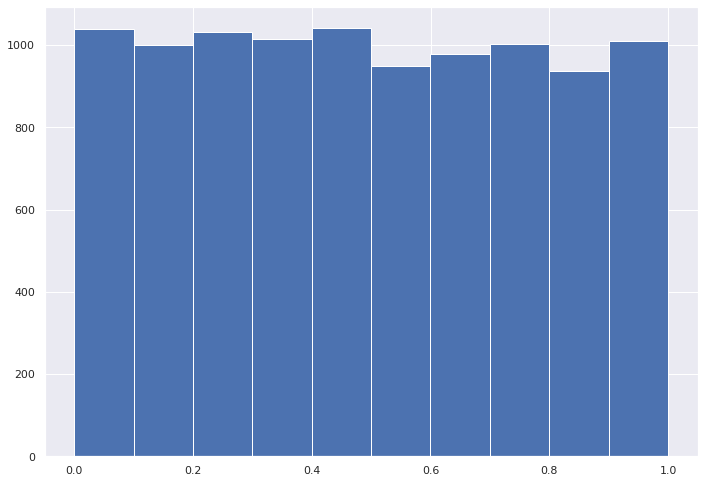

In [217]:
plt.hist(data_pvalue['pvalue'])

In [251]:
low_p = 0
nrm_p = 0
for x in pvalue_list:
    if x <= 0.05:
        low_p = low_p + 1
    else:
        nrm_p = nrm_p + 1 

result = low_p/10000*100
print(result,'% p values оказался меньше либо равен 0.05' )

5.25 % p values оказался меньше либо равен 0.05
